In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

In [2]:
jobData = pd.read_csv('fake_job_postings.csv')

---
# Extracting `salary_range`

The cleaned salary range are stored in column `salary_lower_limit` and `salary_upper_limit`

for data like "40000-59000", the corresponding lower and upper limits are 40000 and 59000

for data with NaN, they are all stored as (0, 0)

for data with just one value like "40000", lower limit is stored as 0 and upper as 40000

In [3]:
jobData['salary_range'] = jobData['salary_range'].fillna('0')
jobData['salary_range'] = jobData['salary_range'].astype('string')

In [4]:
def extract_salary_range(t):
    split_data = t.split('-')
    
    #For cases with no hyphen, meaning theres only 1 value in the column
    if (len(split_data) != 2):
        
        #If the value is a number, then that number is the upper end, lower end is 0
        if (split_data[0].isnumeric()):
            return (0, int(split_data[0]))
        
        #If there is only 1 value and it is not a number, it is an invalid input
        return (0, 0)
    
    #If there is a hyphen and both ends are numbers, those numbers give the range
    if (split_data[0].isnumeric() and split_data[1].isnumeric()):
        return (int(split_data[0]), int(split_data[1]))
    
    #If there is a hyphen but one of the range is not a number. e.g. "4-Apr"
    return (0, 0)

In [5]:
lower = []
upper = []
for i in range(len(jobData)):
    l, u = extract_salary_range(jobData['salary_range'][i])
    lower.append(l)
    upper.append(u)

jobData["salary_lower_limit"] = lower
jobData["salary_upper_limit"] = upper

In [6]:
#jobData[["salary_range", "salary_lower_limit", "salary_upper_limit"]].head(50)

--- 

# Cleaning `function`, `required_experience`, `employment_type`, `required_education` and `industry` using One-Hot encoding

Columns can be accessed by using `<category>_type_is_<function name>`.

For example, if you want to know whether the job has the function of 'Marketing', simply use `jobPostings["function_type_is_Marketing"]` to generate a column of bool.

In [7]:
jobData["function"].fillna(value='Not specified', inplace=True)
jobData['employment_type'].fillna(value='Not specified', inplace=True)
jobData['required_experience'].fillna(value='Not specified', inplace=True)
jobData['required_education'].fillna(value='Not specified', inplace=True)
jobData['industry'].fillna(value='Not specified', inplace=True)


jobData = jobData.astype({
    'function': 'category',
    'employment_type': 'category',
    'required_experience': 'category',
    'required_education': 'category',
    'industry': 'category',
})

In [8]:
temp = jobData["function"]

jobData = pd.get_dummies(jobData, columns=["function"], prefix=["function_type_is"], dtype="bool")
jobData = jobData.join(temp)

In [9]:
temp = jobData["required_experience"]

jobData = pd.get_dummies(jobData, columns=["required_experience"], prefix=["required_experience_is"], dtype="bool")
jobData = jobData.join(temp)

In [10]:
temp = jobData["employment_type"]

jobData = pd.get_dummies(jobData, columns=["employment_type"], prefix=["employment_type_is"], dtype="bool")
jobData = jobData.join(temp)

In [11]:
temp = jobData["required_education"]

jobData = pd.get_dummies(jobData, columns=["required_education"], prefix=["required_education_is"], dtype="bool")
jobData = jobData.join(temp)

In [12]:
temp = jobData["industry"]

jobData = pd.get_dummies(jobData, columns=["industry"], prefix=["industry"], dtype="bool")
jobData = jobData.join(temp)

In [13]:
#jobData.head(50)

---

# Extract country codes from `location` to column `country_code`

'NS' refers to not being specified, rather than a actual country code.

In [14]:
jobData["location"] = jobData["location"].fillna("NS") # Not specified

In [15]:
def extract_country_code(t):
    return t[:2]

In [16]:
code = []
for i in range(len(jobData)):
    code.append(extract_country_code(jobData["location"][i]))

jobData["country_code"] = code
jobData["country_code"] = jobData["country_code"].astype("category")

In [17]:
temp = jobData["country_code"]

# generate binary values using get_dummies
jobData = pd.get_dummies(jobData, columns=["country_code"], prefix=["country_code_is"], dtype="bool")
jobData = jobData.join(temp)

In [18]:
#jobData.dtypes

---

# Convert `telecommuting`, `has_company_logo`, `has_questions` columns dtype to bool



In [19]:
jobData['telecommuting'] = jobData['telecommuting'].astype(bool)
jobData['has_company_logo'] = jobData['has_company_logo'].astype(bool)
jobData['has_questions'] = jobData['has_questions'].astype(bool)

---
# Applying NLP to generate `NLP_pred`


In [20]:
jobData = jobData.astype({
    'title': 'string',
    'department': 'string',   
    'company_profile': 'string',
    'description': 'string',
    'requirements': 'string',
    'benefits': 'string',
})

In [21]:
jobData['department'].fillna(value='NODEPARTMENT', inplace=True)
jobData['company_profile'].fillna(value='NOCOMPANYPROFILE', inplace=True)
jobData['description'].fillna(value='NODESCRIPTION', inplace=True)
jobData['requirements'].fillna(value='NOREQUIREMENTS', inplace=True)
jobData['benefits'].fillna(value='NOBENEFITS', inplace=True)

In [22]:
documents = jobData[['title', 'department', 'company_profile', 'description', 'requirements', 'benefits']].agg(' '.join, axis=1)
documents

0        Marketing Intern Marketing We're Food52, and w...
1        Customer Service - Cloud Video Production Succ...
2        Commissioning Machinery Assistant (CMA) NODEPA...
3        Account Executive - Washington DC Sales Our pa...
4        Bill Review Manager NODEPARTMENT SpotSource So...
                               ...                        
17875    Account Director - Distribution  Sales Vend is...
17876    Payroll Accountant Accounting WebLinc is the e...
17877    Project Cost Control Staff Engineer - Cost Con...
17878    Graphic Designer NODEPARTMENT NOCOMPANYPROFILE...
17879    Web Application Developers Engineering Vend is...
Length: 17880, dtype: object

In [23]:
from nltk import pos_tag
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer

#Initializes objects needed to perform cleaning
regex_token = RegexpTokenizer(r'[a-zA-Z0-9\-]+')
stop_words = set(stopwords.words('english')) 
lem = WordNetLemmatizer()

#Converts part of speech tag from treebank syntax to wordnet syntax
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    return 'v'

#Function to tokenize, filter stop words and lemmatize words in text data
def pre_process_lem(text):
    
    #perform tokenization to obtain a list of words, with each word as an individual element
    tokenized_text = regex_token.tokenize(text.lower())
    
    #Filter out stop words with a loop, adding filtered words to a new list
    filtered_tokens=[]
    for word in tokenized_text:
        if word not in stop_words:
            filtered_tokens.append(word)
    
    #Tags filtered words with their relevant part of speech. Tagging is necessary for lemmatization.
    #Returns a tuple (<word>, <tag>), but tag is in treebank syntax.
    tagged_words = pos_tag(filtered_tokens)
    
    #Uses a loop to lemmatize words then add them to a new list
    lemmed_words = []
    for tagged_word in tagged_words:
        #Lemmatizer method takes in (<word>, pos=<tag>) as inputs
        #The get_wordnet_pos() method is needed to convert tags from treebank syntax to wordnet syntax.
        lemmed_word = lem.lemmatize( tagged_word[0] , pos=get_wordnet_pos(tagged_word[1]) )
        lemmed_words.append(lemmed_word)
        
    return " ".join(lemmed_words)

In [24]:
lemmatized_documents = documents.apply(pre_process_lem)

In [25]:
jobData["lemmatized_documents"] = lemmatized_documents
lemmatized_documents

0        marketing intern marketing food52 create groun...
1        customer service - cloud video production succ...
2        commission machinery assistant cma nodepartmen...
3        account executive - washington dc sale passion...
4        bill review manager nodepartment spotsource so...
                               ...                        
17875    account director - distribution sale vend look...
17876    payroll accountant accounting weblinc e-commer...
17877    project cost control staff engineer - cost con...
17878    graphic designer nodepartment nocompanyprofile...
17879    web application developer engineering vend loo...
Length: 17880, dtype: object

## NLP Model

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
#Bigram is used. It finds count of each pair words in the text. feature extraction
cv = CountVectorizer(ngram_range=(2,2))

#Vectorizer converts the list of words into a proper matrix of word counts for each word, for each data entry
X_text_data = cv.fit_transform(lemmatized_documents)
y_text_data = jobData['fraudulent']
X_text_data

<17880x893991 sparse matrix of type '<class 'numpy.int64'>'
	with 4116089 stored elements in Compressed Sparse Row format>

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(X_text_data, y_text_data, test_size=0.3)
mnb = MultinomialNB()
mnb.fit(X_text_train, y_text_train)

MultinomialNB()

Accuracy:	 0.9894534995206136
F1 score:	 0.9007518796992482


<AxesSubplot:>

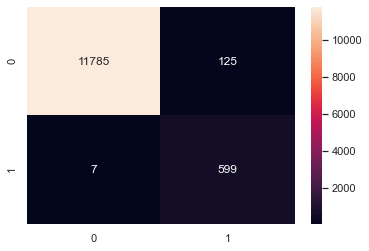

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

pred_text_train = pd.DataFrame(mnb.predict(X_text_train), columns=['prediction'], index=y_text_train.index)

print("Accuracy:\t", mnb.score(X_text_train, y_text_train))
print("F1 score:\t", f1_score(y_text_train, pred_text_train))
sb.heatmap(confusion_matrix(y_text_train, pred_text_train), annot=True, fmt='d')

Accuracy:	 0.9149888143176734
F1 score:	 0.4922048997772829


<AxesSubplot:>

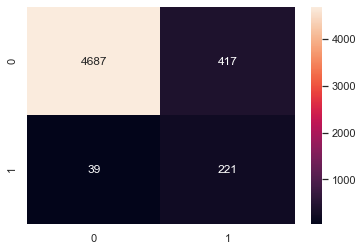

In [29]:
pred_text_test = pd.DataFrame(mnb.predict(X_text_test), columns=['prediction'], index=y_text_test.index)

print("Accuracy:\t", mnb.score(X_text_test, y_text_test))
print("F1 score:\t", f1_score(y_text_test, pred_text_test))
sb.heatmap(confusion_matrix(y_text_test, pred_text_test), annot=True, fmt='d')

In [30]:
nlp_pred = pd.DataFrame(mnb.predict_proba(X_text_data), columns=['nlp_p_real', 'nlp_p_fraud'])['nlp_p_fraud']
nlp_pred

0        7.167834e-157
1        1.053428e-298
2        2.548992e-126
3         0.000000e+00
4        5.211936e-188
             ...      
17875     0.000000e+00
17876    5.754823e-185
17877    8.308777e-143
17878     8.574915e-32
17879     0.000000e+00
Name: nlp_p_fraud, Length: 17880, dtype: float64

In [31]:
jobData["NLP_Pred"] = nlp_pred

---

# Exporting the cleaned dataset

In [32]:
jobData.dtypes

job_id                     int64
title                     string
location                  object
department                string
salary_range              string
                          ...   
country_code_is_ZA          bool
country_code_is_ZM          bool
country_code            category
lemmatized_documents      object
NLP_Pred                 float64
Length: 312, dtype: object

In [33]:
jobData.to_csv('cleaned_data.csv', index=False) 